In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Лабораторная работа №6

In [3]:
import random
from itertools import islice
from operator import attrgetter
from typing import Generator, Iterable, NamedTuple, Tuple, TypeVar

import numpy as np
from matplotlib import markers
from matplotlib import pyplot as plt
from matplotlib.image import imread
from more_itertools import last, unzip
from nptyping import Array
from scipy.io import loadmat
from sklearn.cluster import AgglomerativeClustering

from util import disable_axes_ticks

# marker consts should be named like this: UPPERCASE_NAME
ALL_MARKERS = tuple(value for name, value in vars(markers).items() if name.isupper())

## Загрузка данных

In [4]:
DATA = loadmat("ex6data1.mat")
X = DATA["X"]

ParamType = TypeVar("ParamType")
Example = Array[...]
ExampleMatrix = Array[Example, ...]


## Отображение входных данных

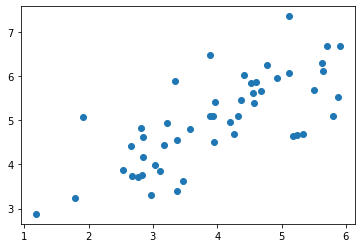

In [5]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()


### Функция случайной инициализации K центров кластеров

In [6]:
def random_centroids(x: ExampleMatrix, k: int) -> ExampleMatrix:
    return x[np.random.choice(x.shape[0], size=k)]


### Функция вычисления расстояний до точки

In [7]:
def get_distance(examples: ExampleMatrix, dest: Example):
    return np.sqrt(np.sum(np.square(examples - dest), axis=1))


### Функция определения принадлежности кластеру

In [8]:
class Cluster(NamedTuple):
    centroid: Example
    elements: ExampleMatrix


def get_cluster_indices(examples: ExampleMatrix, centroids: Iterable[Example]):
    distances = np.array([get_distance(examples, c) for c in centroids])
    return np.argmin(distances, axis=0)


def clusterize(
    examples: ExampleMatrix, centroids: Iterable[Example]
) -> Tuple[Cluster, ...]:
    cluster_indices = get_cluster_indices(examples, centroids)
    return tuple(
        Cluster(centroid=centroid, elements=examples[cluster_indices == cluster_index])
        for cluster_index, centroid in enumerate(centroids)
    )


### Функция стоимости
\begin{equation}
J(c^{(1)}, \ldots, c^{(m)}, \mu_1, \ldots, \mu_K) =
\frac{1}{m} \sum_{i=1}^m \left\Vert x^{(i)} - \mu_{c^{(i)}} \right\Vert^2
\end{equation}

In [9]:
def clusterization_cost(clusters: Iterable[Cluster]) -> ParamType:
    return sum(
        np.sum(get_distance(cluster.elements, cluster.centroid)) for cluster in clusters
    )


### Функция пересчёта центров кластеров

In [10]:
def get_new_centroids(clusters: Iterable[np.ndarray]) -> Tuple[Example, ...]:
    return tuple(np.mean(cluster, axis=0) for cluster in clusters)


## Алгоритм K-средних

In [11]:
def k_means(
    k: int, examples: ExampleMatrix
) -> Generator[Tuple[Cluster, ...], None, None]:
    centroids = random_centroids(examples, k)
    while True:
        clusters = clusterize(examples, centroids)
        yield clusters
        centroids = get_new_centroids(c.elements for c in clusters)


## Разделение исходных данных на K=3 кластеров

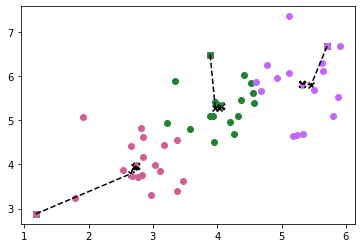

In [12]:
ITER_COUNT = 100

CLUSTER_COUNT = 3

CLUSTER_COLORS = tuple(
    f"#{color:06X}"
    for color in random.sample(range(int("ffffff", base=16)), CLUSTER_COUNT)
)

CENTROID_MARKERS = random.sample(ALL_MARKERS, CLUSTER_COUNT)

cluster_sets = tuple(islice(k_means(CLUSTER_COUNT, X), ITER_COUNT))
latest_cluster_set = cluster_sets[-1]

centroid_sets = tuple(
    tuple(cluster.centroid for cluster in cluster_set) for cluster_set in cluster_sets
)
centroid_paths = tuple(
    tuple(centroid_path_gen) for centroid_path_gen in unzip(centroid_sets)
)
for centroid_path, color in zip(centroid_paths, CLUSTER_COLORS):
    x_vals = tuple(c[0] for c in centroid_path)
    y_vals = tuple(c[1] for c in centroid_path)
    plt.plot(x_vals, y_vals, linestyle="--", color="black")
    plt.scatter(x_vals, y_vals, color="black", marker="x")

for cluster, color, marker in zip(latest_cluster_set, CLUSTER_COLORS, CENTROID_MARKERS):
    plt.scatter(cluster.elements[:, 0], cluster.elements[:, 1], color=color)
    plt.scatter(
        cluster.centroid[0], cluster.centroid[1], marker=marker, color=color, s=30
    )

plt.show()


## Загрузка и отображение изображения

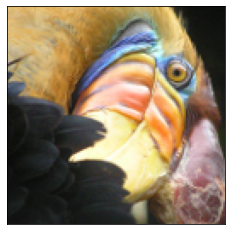

In [13]:
BIRD_SMALL = loadmat("bird_small.mat")
BIRD_IMG = BIRD_SMALL["A"]

plt.imshow(BIRD_IMG)
disable_axes_ticks(plt)
plt.show()


### Изменение размеров изображения

In [14]:
BIRD_IMG_ORIGINAL_SHAPE = BIRD_IMG.shape
print(f"Original image shape: {BIRD_IMG_ORIGINAL_SHAPE}")

BIRD_IMG_ROWS, BIRD_IMG_COLS, BIRD_IMG_COLOR_BYTES = BIRD_IMG_ORIGINAL_SHAPE
BIRD_IMG_RESHAPED = BIRD_IMG.reshape(BIRD_IMG_ROWS * BIRD_IMG_COLS, BIRD_IMG_COLOR_BYTES)

print(f"Reshaped image shape: {BIRD_IMG_RESHAPED.shape}")


Original image shape: (128, 128, 3)
Reshaped image shape: (16384, 3)


### Применение алгоритма K-средних для сжатия изображения

In [15]:
COLOR_COUNT = 16

bird_img_clusters = last(islice(k_means(COLOR_COUNT, BIRD_IMG_RESHAPED), 100))
bird_img_centroids = tuple(cluster.centroid for cluster in bird_img_clusters)
bird_img_cluster_indices = get_cluster_indices(BIRD_IMG_RESHAPED, bird_img_centroids)

# Total size = sum of centroid sizes + size of index array
compressed_img_size = (
    sum(map(attrgetter("nbytes"), bird_img_centroids))
    + bird_img_cluster_indices.nbytes
)
original_img_size = BIRD_IMG.nbytes
print(f"Compressed image size: {compressed_img_size}")
print(f"Original image size: {original_img_size}")
print(f"Compression coefficient: {original_img_size / compressed_img_size:.1%}")


Compressed image size: 131456
Original image size: 49152
Compression coefficient: 37.4%


### Восстановление изображения

In [16]:
def reconstruct(
    cluster_indices: np.ndarray, centroids: Iterable[Example]
) -> ExampleMatrix:
    return np.array(centroids)[cluster_indices]


### Закодированное и оригинальное изображения

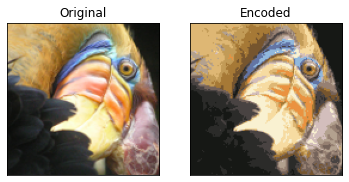

In [17]:
bird_img_color_encoded = np.rint(
    reconstruct(
        bird_img_cluster_indices,
        bird_img_centroids
    ).reshape(BIRD_IMG_ORIGINAL_SHAPE)
).astype(BIRD_IMG.dtype)


_, (original_axes, encoded_axes) = plt.subplots(1, 2)

original_axes.set_title("Original")
disable_axes_ticks(original_axes)
original_axes.imshow(BIRD_IMG)

encoded_axes.set_title("Encoded")
disable_axes_ticks(encoded_axes)
encoded_axes.imshow(bird_img_color_encoded)

plt.show()

## Новое изображение

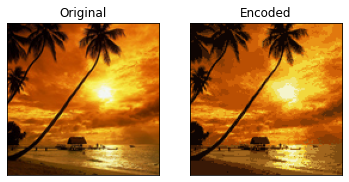

In [18]:
# Translate array from floats in range between 0 and 1
# to ints between 0 and 255, changing bit-depth from 32 to 24 bits.
NICE_IMG = np.rint(imread("nice.png") * 255).astype(BIRD_IMG.dtype)
NICE_IMG_ORIGINAL_SHAPE = NICE_IMG.shape
NICE_IMG_ROWS, NICE_IMG_COLS, NICE_IMG_COLOR_BYTES = NICE_IMG_ORIGINAL_SHAPE
NICE_IMG_RESHAPED = NICE_IMG.reshape(
    NICE_IMG_ROWS * NICE_IMG_COLS,
    NICE_IMG_COLOR_BYTES
)

nice_img_clusters = last(islice(k_means(COLOR_COUNT, NICE_IMG_RESHAPED), 100))
nice_img_centroids = tuple(cluster.centroid for cluster in nice_img_clusters)
nice_img_cluster_indices = get_cluster_indices(NICE_IMG_RESHAPED, nice_img_centroids)
nice_img_color_encoded = np.rint(
    reconstruct(
        nice_img_cluster_indices,
        nice_img_centroids
    ).reshape(NICE_IMG_ORIGINAL_SHAPE)
).astype(BIRD_IMG.dtype)

_, (original_axes, encoded_axes) = plt.subplots(1, 2)

original_axes.set_title("Original")
disable_axes_ticks(original_axes)
original_axes.imshow(NICE_IMG)

encoded_axes.set_title("Encoded")
disable_axes_ticks(encoded_axes)
encoded_axes.imshow(nice_img_color_encoded)

plt.show()


## Иерархическая кластеризация

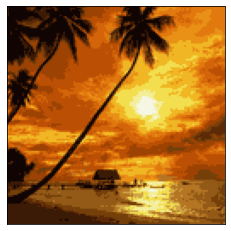

In [19]:
model = AgglomerativeClustering(n_clusters=COLOR_COUNT)
agg_cluster_indices = model.fit_predict(NICE_IMG_RESHAPED)
agg_centroids = get_new_centroids(
    NICE_IMG_RESHAPED[agg_cluster_indices == i]
    for i in range(COLOR_COUNT)
)
agg_encoded = np.rint(
    reconstruct(agg_cluster_indices, agg_centroids).reshape(NICE_IMG_ORIGINAL_SHAPE)
).astype(BIRD_IMG.dtype)

disable_axes_ticks(plt)
plt.imshow(agg_encoded)

plt.show()